# Avaliação 6: Classificação - Knn, Regressão Logistica, Naive Bayes.


Francisco Aparecido Rodrigues, francisco@icmc.usp.br.<br>
Universidade de São Paulo, São Carlos, Brasil.<br>
Copyright (c) 2020.

## Bibliotecas

In [3]:
# importando bibliotecas que serão utilizadas é uma boa pratica de programação importa-las no inicio e não no meio do código
import cufflinks as cf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import itertools
import time as time
import warnings

from mlxtend.plotting import plot_decision_regions
from plotly.offline import iplot

from sklearn import datasets, metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.metrics import silhouette_score, r2_score, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # modulo para padronizar os dados
from sklearn.preprocessing import MinMaxScaler   # modulo para normalizar os dados
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, LabelEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

from statistics import variance


warnings.filterwarnings("ignore")

## Vertebral Column 3C database

## Funções

In [161]:
#-----------------------------------------------------------------------------------
def detecta_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    matches = ((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr)))
    return df[matches.any(1)]


#-----------------------------------------------------------------------------------
# Confusion matrix: [ TP  FP
#                     FN  TN ]
# True Positive (TP): Outcome where the model correctly predicts the positive class.
# True Negative (TN): Outcome where the model correctly predicts the negative class.
# False Positive (FP): Also called a type 1 error, an outcome where the model incorrectly predicts the positive class when it is actually negative.
# False Negative (FN): Also called a type 2 error, an outcome where the model incorrectly predicts the negative class when it is actually positive.
#
def confusion_matrix_scores(y_test, y_pred, cm_acurracy_score, cm_recall_score, cm_precision_score, cm_f1_score):
    #
    # Confusion Matrix Metrics:
    #print(colors.bold + "\nConfusion Matrix Metrics:" + colors.reset)
    #
    # A) Accuracy score
    # This is simply equal to the proportion of predictions that the model classified correctly.
    # Formula: TP + TN / (TP + TN + FP + FN)
    Accuracy = accuracy_score(y_test, y_pred)
    cm_acurracy_score.append(Accuracy)
    #print((colors.bold + "A) Accuracy score:" + colors. reset + "{:.2f}%" ).format(100*Accuracy))
    #
    # B) Recall score
    # Recall, also known as the sensitivity, hit rate, or the true positive rate (TPR), is the proportion of the total amount of relevant instances that were actually retrieved. 
    # It answers the question “What proportion of actual positives was identified correctly?”
    # Formula: TP / (TP + FN)
    Recall = recall_score(y_test, y_pred, average=None)
    cm_recall_score.append(Recall)   
    #print(colors.bold + "B) Recall scores:" + colors. reset)
    #for i in range(0,len(classes)):
    #       print("- Classe {:s}: {:.2f}%".format(classes[i], 100*Recall[i]))
    #
    # Precision score
    # Specificity, also known as the true negative rate (TNR), measures the proportion of actual negatives that are correctly identified as such. 
    # It is the opposite of recall.
    # Formula: TN / (TN + FP)
    Precision = precision_score(y_test, y_pred, average=None)
    cm_precision_score.append(Precision)
    #print(colors.bold + "C) Precision scores:" + colors. reset)
    #for i in range(0,len(classes)):
    #       print("- Classe {:s}: {:.2f}%".format(classes[i], 100*Precision[i]))
    #
    # F1 score
    # The F1 score is a measure of a test’s accuracy — it is the harmonic mean of precision and recall. 
    # It can have a maximum score of 1 (perfect precision and recall) and a minimum of 0. 
    # Overall, it is a measure of the preciseness and robustness of your model.
    # Formula = 2TP /(aTP + FP + FN)
    F1 = f1_score(y_test, y_pred, average=None)
    cm_f1_score.append(F1)
    #print(colors.bold + "D) F1 scores:" + colors. reset)
    #for i in range(0,len(classes)):
    #       print("- Classe {:s}: {:.2f}%".format(classes[i], 100*F1[i]))
    return(cm_acurracy_score, cm_recall_score, cm_precision_score, cm_f1_score)
            
#---------------------------------------------------------------------------------------
# correlation heat map setup for seaborn
def plot_sns_heatmap(data, cmap, title):
    # Dimensões da matriz de dados
    nrow,ncol = data.shape
    # Cálculo da matrix de correlações
    corr = data.iloc[:,0:ncol].corr()

    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(corr, 
                xticklabels=corr.columns,
                yticklabels=corr.columns, 
                mask=top, 
                cmap=cmap, 
                annot=True, 
                fmt=".2f",
                center=0, 
                ax=ax) 
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 0)
    plt.title("co-variance matrix heatmap (source = " + title +')', fontsize = 16)
    format_plot(ax)
    plt.grid(False)
    plt.show()
    
#---------------------------------------------------------------------------------------
#create histogram and density plots to examine distributions
# saves image to pdf
def plot_hist_density(data, features, dataname, title):
    #d = data
    #f = features
    #g = pd.melt(d, value_vars = f)
    #gm = sns.FacetGrid(g, col='variable', col_wrap = 4, sharex = False, sharey = False)
    #gm = gm.map(sns.distplot,'value')
    #plt.tight_layout()
    #plt.suptitle(title, x = 0.5, y = 1.06, fontsize = 14)
    #plt.savefig('Hist-Density-{}.pdf'.format(dataname), 
    #            bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    #            orientation='portrait', papertype=None, format=None, 
    #            transparent=True, pad_inches=0.25, frameon=None)
    #plt.show()
    
    cols = 2 # Numero de colunas para o Subplot
    nrows, ncols = (math.ceil(len(features) / cols), cols) # Cálculo de rows e cols subplots deve ter
    f, axes = plt.subplots(nrows, ncols, figsize=(10,8)) # Cria subplot
    for n in np.arange(0,nrows):
        for c in np.arange(0,cols):
            sns.distplot(df[features[n*2+c]], ax=axes[n,c], bins=20)
    plt.tight_layout()
    plt.suptitle(title, x = 0.5, y = 1.02, fontsize = 16)
    plt.show()
    
#---------------------------------------------------------------------------------------
# creates/shows seaborn boxplot
def plot_boxplot(data, features, dataname, title):
    d = data
    f = features
    g = pd.melt(d, value_vars = f)
    gm = sns.FacetGrid(g, col='variable', col_wrap = 4, sharex = False, sharey = False)
    gm = gm.map(sns.boxplot, 'value')
    
    plt.tight_layout()
    plt.suptitle(title, x = 0.5, y = 1.01, fontsize = 15)
    #plt.savefig('Boxplot-{}.pdf'.format(dataname), 
    #            bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    #            orientation='portrait', papertype=None, format=None, 
    #            transparent=True, pad_inches=0.25, frameon=None)
    plt.show()
    plt.close()

#---------------------------------------------------------------------------------------
# data balance plot
def plot_balanceamento_dados(data, title):
    Classes = data[df.columns[-1]] #Coluna "class"
    cl = np.unique(Classes) # armazena os nomes das classes das especies
    print("Classes disponiveis:" + str(cl))
    #----------------------------------------------------
    # armazena o número de elementos em cada classe
    ncl = np.zeros(len(cl))
    ncp = np.zeros(len(cl))
    for i in np.arange(0, len(cl)):
        a = Classes == cl[i]
        ncl[i] = len(Classes[a])
        print("{:4s}: {:d}".format(str(cl[i]),int(ncl[i])))
    for i in np.arange(0, len(ncl)):
        ncp[i] = ncl[i]/np.sum(ncl)
    
    #----------------------------------------------------
    # número de classes
    numbers = np.arange(0, len(cl))
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(x=cl, y=ncl, ax=ax, data=data, palette='Set2')
    ax.set_title(title, fontdict={'fontsize':15})
    ax.set_xlabel('Classes', fontdict={'fontsize':13})
    ax.set_ylabel('Quantidade', fontdict={'fontsize':13})
    ax.tick_params(labelsize=13)
    format_plot(ax)
    fig.tight_layout();
    
    
#---------------------------------------------------------------------------------------
# creates/shows seaborn pairplot (scatter matrix)
def plot_scatter_matrix(data, features, dataname, title):
    sns.pairplot(data)
    plt.tight_layout()
    plt.suptitle(title, x = 0.5, y = 1.00, fontsize = 15)
    #plt.savefig('Scatte-Matrix-{}.pdf'.format(dataname), 
    #            bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    #            orientation='portrait', papertype=None, format=None, 
    #            transparent=True, pad_inches=0.25, frameon=None)
    plt.show()
    plt.close()

#------------------------------------------------------------------------------------------    
def plot_KNeighbors_scores(K, Score_test, Score_train):
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(K, Score_train, '-ro', label = 'Accuracy (train)')
    plt.plot(K, Score_test, '-bo', label = 'Accuracy (test)')
    plt.legend()
    plt.title('Accuracy model vs k values (Number of Neighbors)', fontsize=15)
    plt.xlabel('Number of Neighbors', fontsize=13)
    plt.ylabel('Accurancy', fontsize=13)
    ax.tick_params(labelsize=13)
    format_plot(ax)
    plt.xticks(K)
    plt.show()

    Bk = np.argmax(Score_test)
    print("Best k: {:02d} (accurancy test set: {:.4f}) ".format(Bk+1, Score_test[Bk]))
    
    return(Bk+1)

#-----------------------------------------------------------------------------------
# This function prints and plots the confusion matrix. Normaliza
def plot_confusion_matrix(cm, classes, normalize, title, cmap):
    
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(4)
        print(colors.bold + '\nNormalized confusion matrix:' + colors.reset)
    else:
        print(colors.bold + '\nConfusion matrix, without normalization:' + colors.reset)
    #print(cm)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.ylabel('True labels', fontsize=13)
    plt.xlabel('Predicted labels', fontsize=13)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    format_plot(ax)
    plt.show()
    
#-----------------------------------------------------------------------------------
def plot_real_predicted_values(classifier, X, y, y_pred):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(y, color='darkblue', linewidth=0, marker='o', markeredgecolor='black', label='Real') 
    plt.plot(y_pred, color='red', linewidth=0, marker='o', markeredgecolor='black', label='Prediction') 
    plt.title("Real and Predicted diagnoses (" + classifier + ")", fontsize=15)
    plt.xlabel("Samples", fontsize=13)
    plt.ylabel("Real and Predicted values", fontsize=13)
    format_plot(ax)
    plt.legend
    plt.show(True)  
    
#-----------------------------------------------------------------------------------
def format_plot(ax):
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(3)
        spine.set_linestyle('--')
        
#---------------------------------------------------------------------------------------------
# Python program to print colored text and background 
class colors: 
    reset            ='\033[0m'
    bold             ='\033[01m'
    disable          ='\033[02m'
    underline        ='\033[04m'
    reverse          ='\033[07m'
    strikethrough    ='\033[09m'
    invisible        ='\033[08m'
    dim              ='\033[2m'
    blink            ='\033[5m'
    hidden           ='\033[8m'

    class fg: 
        black        ='\033[30m'
        red          ='\033[31m'
        green        ='\033[32m'
        orange       ='\033[33m'
        blue         ='\033[34m'
        purple       ='\033[35m'
        cyan         ='\033[36m'
        yellow       ='\033[93m'
        pink         ='\033[95m'
        white        ="\033[97m"
        darkgrey     ='\033[90m'
        lightgrey    ='\033[37m'
        lightred     ='\033[91m'
        lightgreen   ='\033[92m'
        LightYellow  ='\033[93m'
        lightblue    ='\033[94m'
        lightcyan    ='\033[96m'
    
    class bg: 
        default      ='\x1b[49m'
        black        ='\033[40m'
        red          ='\033[41m'
        green        ='\033[42m'
        orange       ='\033[43m'
        blue         ='\033[44m'
        purple       ='\033[45m'
        cyan         ='\033[46m'
        lightgrey    ='\033[47m'
        

In [45]:
np.random.seed(42) # define the seed (important to reproduce the results)
sns.set() #apenas para deixar o plot mais "bonitinho" com fundo cinza e com grid

# leitura dos dados
df = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))

# Matriz de dados
nrow, ncol = df.shape
print("Matriz de atributos: Número de linhas:", nrow, " colunas: ", ncol)
features = list(df.columns)

# armazena os nomes únicos das classes
#classes = np.array(pd.unique(df[df.columns[-1]]), dtype=str) 
classes = list(df['class'].unique())
print('Classes: ', classes)

# Como converter a coluna 'class' em números?
classes_n = df['class'].astype('category').cat.codes
#print('Classes_n: ', np.array(pd.unique(classes_n)))
print('Classes_n: ', list(pd.unique(classes_n)))


Matriz de atributos: Número de linhas: 310  colunas:  7
Classes:  ['Hernia', 'Spondylolisthesis', 'Normal']
Classes_n:  [0, 2, 1]


In [22]:
# Como usar a função iloc para dataframe
df.iloc[0:10,0:2] # seleciona as 10 primeiras linhas, as 2 primeiras colunas
df.iloc[0:10][['sacral_slope','pelvic_radius']]
df.iloc[0:10]

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,Hernia
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,Hernia
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,Hernia
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,Hernia
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,Hernia


In [46]:
df.head(10)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,Hernia
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,Hernia
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,Hernia
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,Hernia
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,Hernia


In [47]:
df.dtypes

pelvic_incidence            float64
pelvic_tilt                 float64
lumbar_lordosis_angle       float64
sacral_slope                float64
pelvic_radius               float64
degree_spondylolisthesis    float64
class                        object
dtype: object

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [49]:
detecta_outliers(df)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,Hernia
51,74.433593,41.557331,27.700000,32.876262,107.949304,5.000089,Hernia
65,83.933009,41.286305,62.000000,42.646703,115.012334,26.588100,Spondylolisthesis
71,86.900794,32.928168,47.794347,53.972627,135.075364,101.719092,Spondylolisthesis
75,70.221452,39.822724,68.118403,30.398728,148.525562,145.378143,Spondylolisthesis
76,86.753609,36.043016,69.221045,50.710593,139.414504,110.860782,Spondylolisthesis
83,81.104100,24.794168,77.887020,56.309932,151.839857,65.214616,Spondylolisthesis
84,76.326002,42.396204,57.200000,33.929797,124.267007,50.127457,Spondylolisthesis
85,45.443750,9.906072,45.000000,35.537678,163.071041,20.315315,Spondylolisthesis
95,57.522356,33.647075,50.909858,23.875281,140.981712,148.753711,Spondylolisthesis


In [50]:
# total null value (column-wise)
df.isnull().sum()

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

In [51]:
# total NAN value (column-wise)
df.isna().sum()

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

In [52]:
# Remove NaN
NaN = df.isna().sum() 
if NaN.sum()>0:
    print('Dropping NaN lines...')
    df = df.dropna(axis='rows') 
    
# Uma opção seria substituição dos valores NaN pela média dos valores atuais
# df = df.fillna(df.mean())

### Matriz de correlações e Heamap

In [53]:
cols = list(df.columns)
df[cols[0:-1]].corr().round(3)  # remove a coluna "class"

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
pelvic_incidence,1.000,0.629,0.717,0.815,-0.247,0.639
pelvic_tilt,0.629,1.000,0.433,0.062,0.033,0.398
lumbar_lordosis_angle,0.717,0.433,1.000,0.598,-0.080,0.534
sacral_slope,0.815,0.062,0.598,1.000,-0.342,0.524
pelvic_radius,-0.247,0.033,-0.080,-0.342,1.000,-0.026
degree_spondylolisthesis,0.639,0.398,0.534,0.524,-0.026,1.000


Computing  Co-variance matrix heatmap...



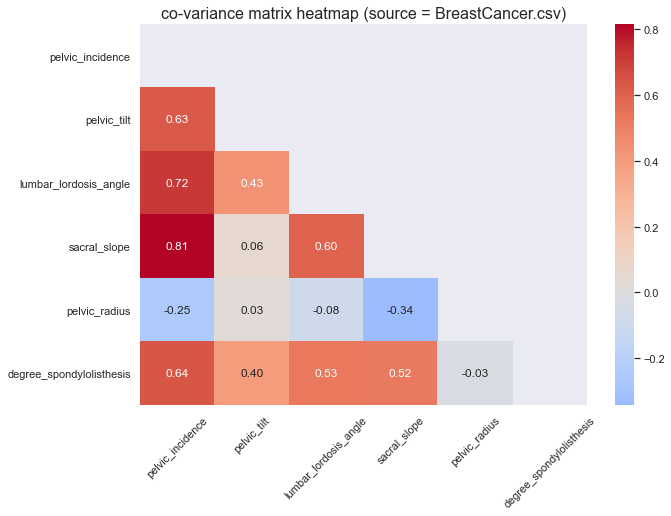


Elapsed time: 0.69s


In [54]:
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Computing  Co-variance matrix heatmap...\n" + colors.reset)
st = time.time()

cols = list(df.columns)

#plot_heatmap(df, cmap, "Boston Housing")
cmap="coolwarm" # "coolwarm", "viridis", PiYG", "RdBu", "Blues", "BuPu", "Greens", "YlGnBu", plt.cm.rainbow
plot_sns_heatmap(df[cols[0:-1]], cmap, "VertebralColumn-3C.csv") # not include feature "class"

elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "\nElapsed time: %.2fs" % elapsed_time + colors.reset)

Compute data balance visualization for  VertebralColumn-3C dataset...

Classes disponiveis:['Hernia' 'Normal' 'Spondylolisthesis']
Hernia: 60
Normal: 100
Spondylolisthesis: 150

Elapsed time: 0.12s


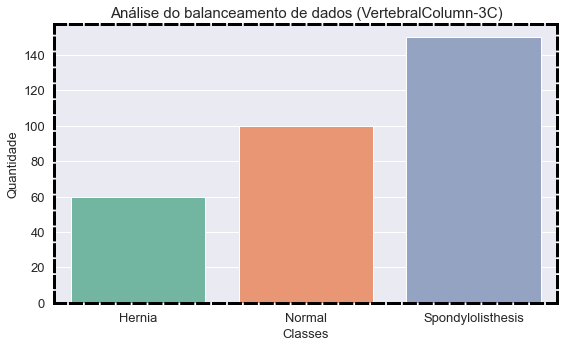

In [55]:
# data balance visualization fpr dataset (ref: 'class')
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Compute data balance visualization for  VertebralColumn-3C dataset...\n" + colors.reset)
st = time.time()

plot_balanceamento_dados(df,"Análise do balanceamento de dados (VertebralColumn-3C)")

elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "\nElapsed time: %.2fs" % elapsed_time + colors.reset)

Compute histogram/density plots for vertebralcolumn-2C dataset...



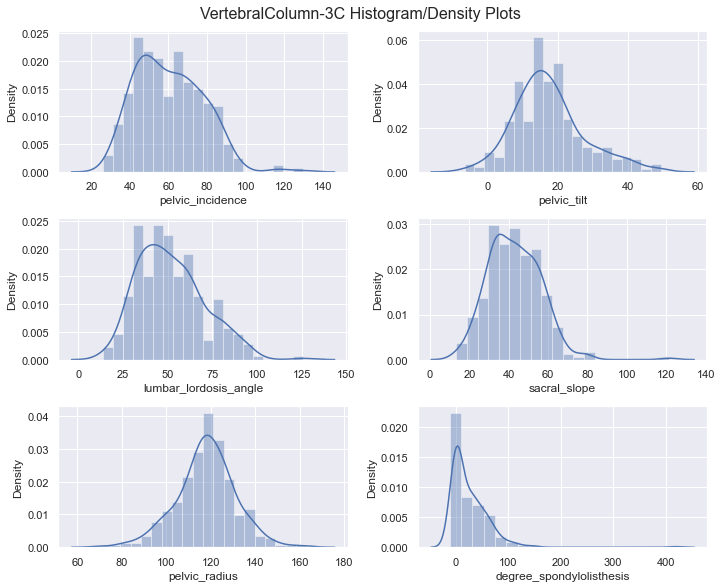


Elapsed time: 1.24s


In [63]:
# histogram/density plots fpr dataset
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Compute histogram/density plots for vertebralcolumn-2C dataset...\n" + colors.reset)
st = time.time()

data = df.drop(df.columns[[-1]], axis=1) 
labels = list(df.columns[0:len(df.columns)-1])

plot_hist_density(data, 
                  labels, 
                  'VertebralColumn-3C', 
                  'VertebralColumn-3C Histogram/Density Plots')
 
elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "\nElapsed time: %.2fs" % elapsed_time + colors.reset)


Classes unicas:  ['Hernia', 'Spondylolisthesis', 'Normal']


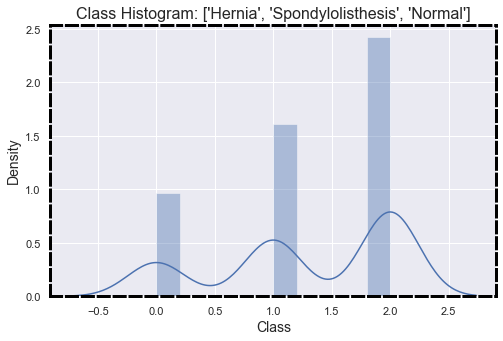

In [89]:
class_n = list(df['class'].astype('category').cat.codes)
classes = list(df['class'].unique())
print(colors.bold + '\nClasses unicas: ' + colors.reset, classes)

fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(class_n, bins=10)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title('Class Histogram: ' + str(list(df['class'].unique())), fontsize=16)
format_plot(ax)
plt.show() 

Compute boxplots for vertebralcolumn-2C dataset...



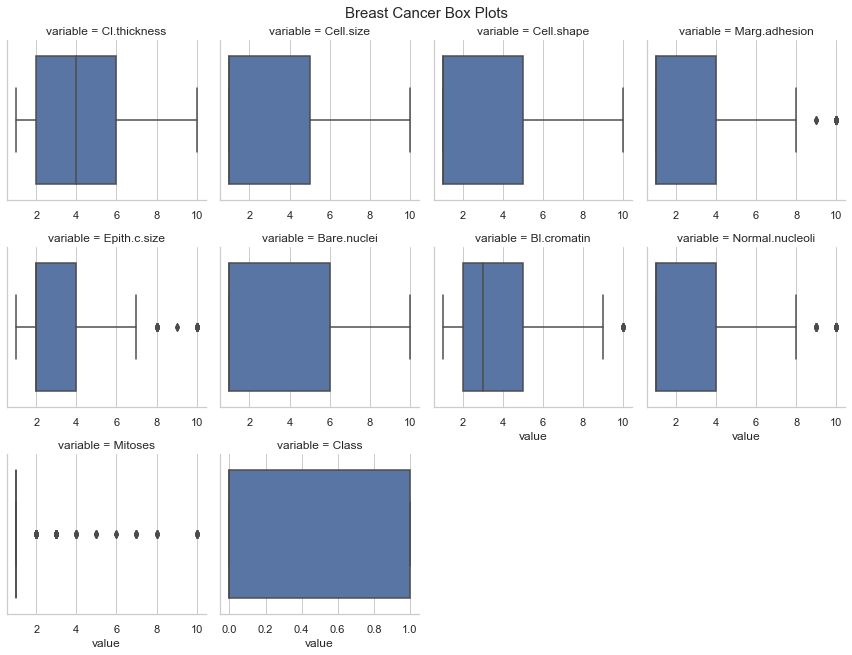


Elapsed time: 11.56s


In [108]:
# boxplots for dataset
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Compute boxplots for vertebralcolumn-2C dataset...\n" + colors.reset)
st = time.time()

#data = df.drop(df.columns[[-1]], axis=1) 
#labels = list(df.columns[0:len(df.columns)-1])
data = df
labels = list(df.columns)

plot_boxplot(data,
             labels, 
             'Breast Cancer', 
             'Breast Cancer Box Plots')

elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "\nElapsed time: %.2fs" % elapsed_time + colors.reset)


Compute boxplots for breast cancer dataset...



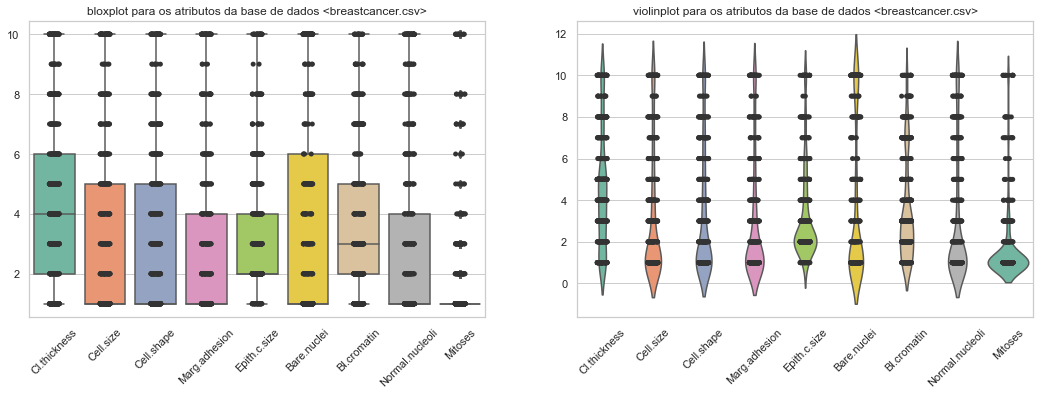

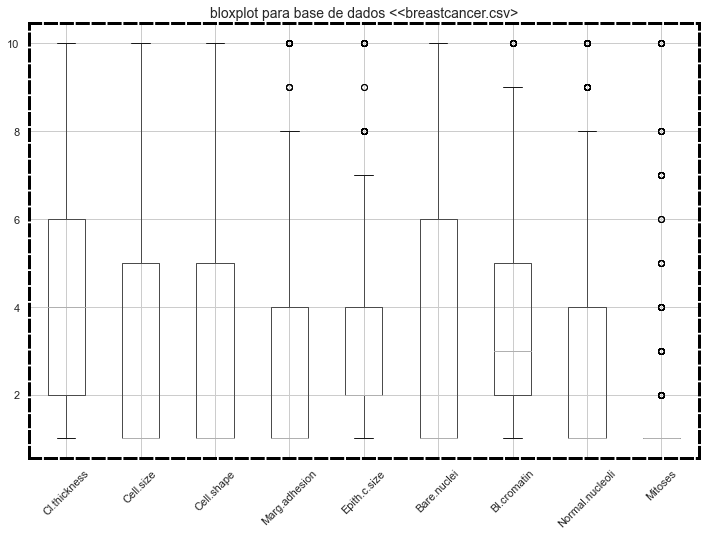


Elapsed time: 4.95s


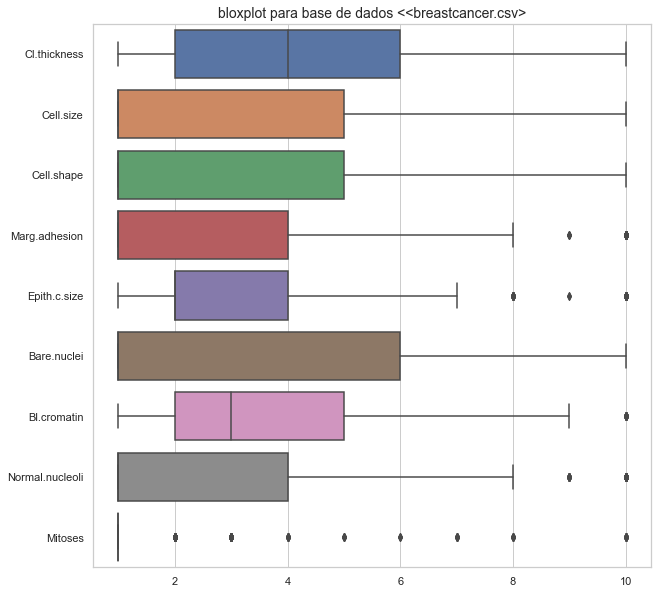

In [109]:
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Compute boxplots for breast cancer dataset...\n" + colors.reset)
st = time.time()

# Bloxplot e Violinplot para os atributos da base de dados <vertebralcolumn-2C>
data = df.drop(df.columns[[-1]], axis=1) 
labels = list(df.columns[0:len(df.columns)-1])

fig, ax = plt.subplots(figsize=(18, 12))
plt.subplot(2,2,1)
sns.boxplot(data=data, orient="v", palette="Set2", whis=np.inf)
sns.stripplot(data=data, color=".2")
plt.title('bloxplot para os atributos da base de dados <breastcancer.csv>', fontsize=12)
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)

plt.subplot(2,2,2)
sns.violinplot(data=data, inner=None, color=".8", palette="Set2")
sns.stripplot(data=data, color=".2")
plt.title('violinplot para os atributos da base de dados <breastcancer.csv>', fontsize=12)
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.show(True)

# Alternative view
fig, ax = plt.subplots(figsize=(12, 8))
data.boxplot(column=labels)
plt.title('bloxplot para base de dados <<breastcancer.csv>', fontsize=14)
format_plot(ax)
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.show(True)

# Alternative view
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.boxplot(data=data, orient="h")
plt.title('bloxplot para base de dados <<breastcancer.csv>', fontsize=14)

elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "\nElapsed time: %.2fs" % elapsed_time + colors.reset)

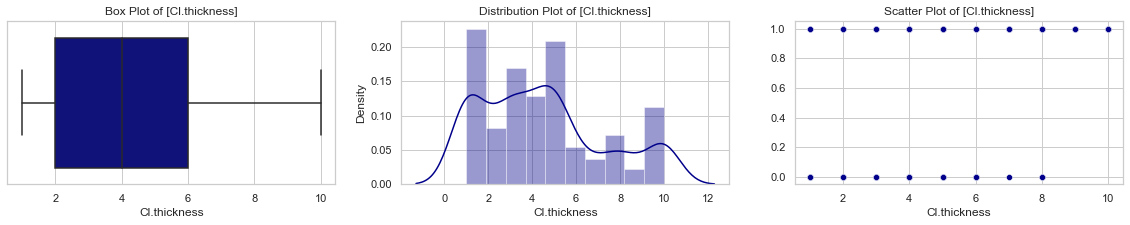

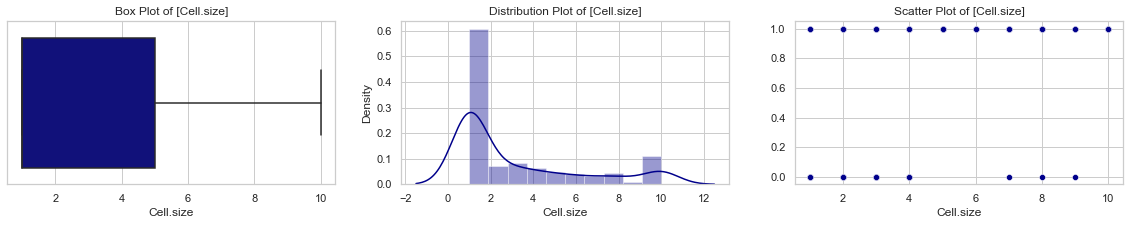

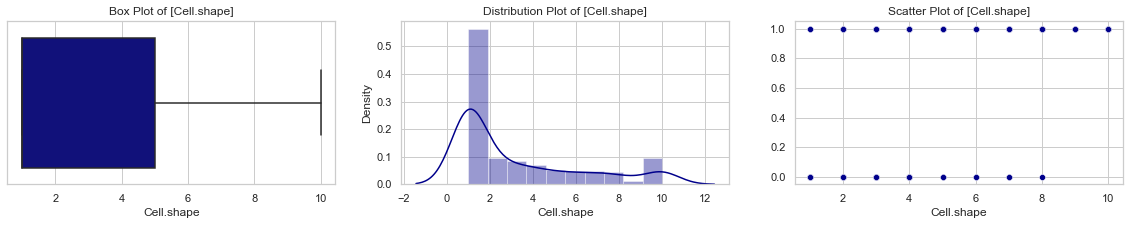

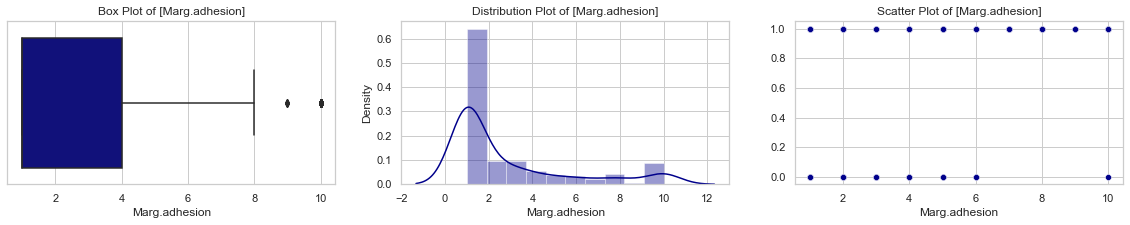

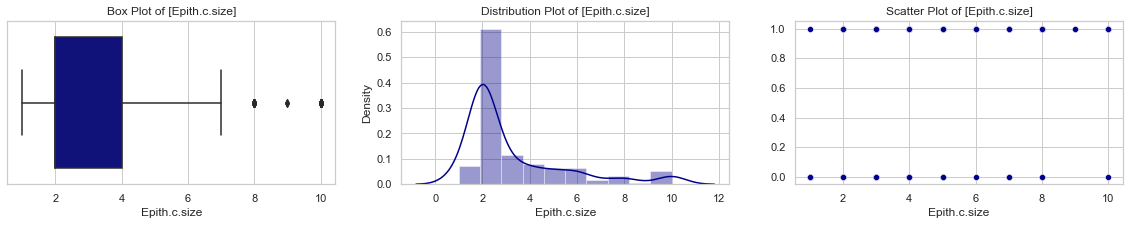

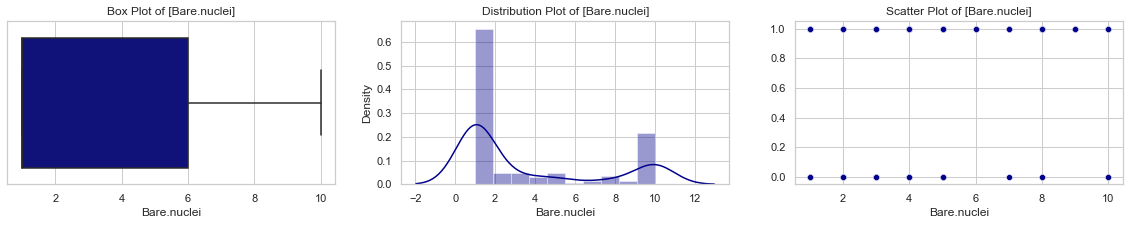

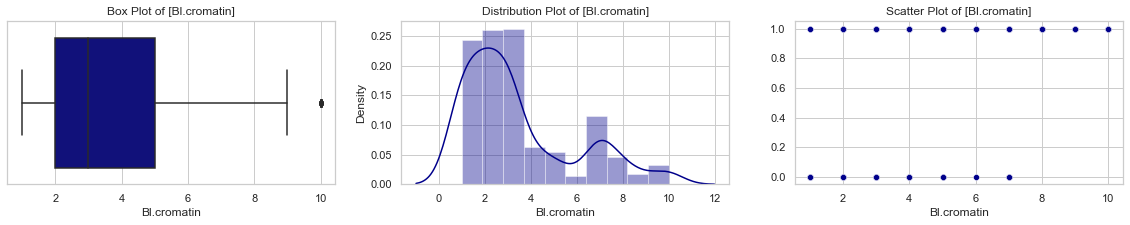

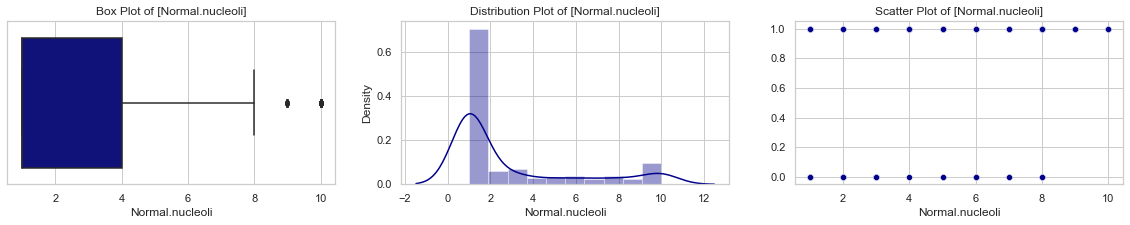

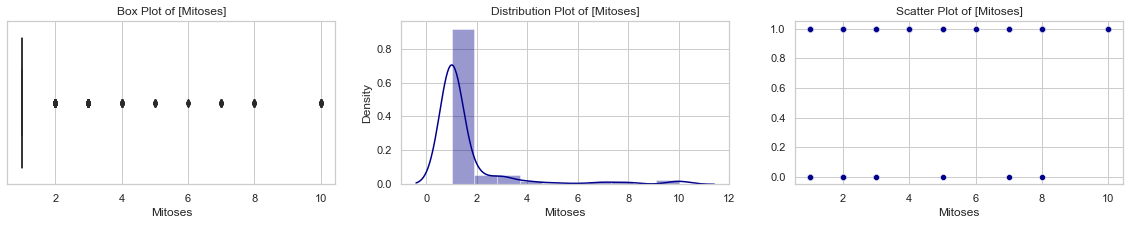

In [110]:
labels = list(df.columns[0:len(df.columns)-1])
data = df.to_numpy()
y = data[:,-1]

for i, feature in list(enumerate(labels)):
    plt.figure(figsize=(20,3))
    plt.subplot(1,3,1)
    sns.boxplot(data[:,i], color="darkblue")
    plt.title('Box Plot of [' + labels[i] + ']')
    plt.xlabel(labels[i])
    plt.subplot(1,3,2)
    sns.distplot(a=data[:,i], bins=10, color="darkblue")
    plt.title('Distribution Plot of [' + labels[i] + ']')
    plt.xlabel(labels[i])
    plt.subplot(1,3,3)
    sns.scatterplot(data[:,i],y, color="darkblue")
    plt.title('Scatter Plot of [' + labels[i] + ']')
    plt.xlabel(labels[i])
    plt.show()

Compute scatter matrix for Breast Cancer dataset...



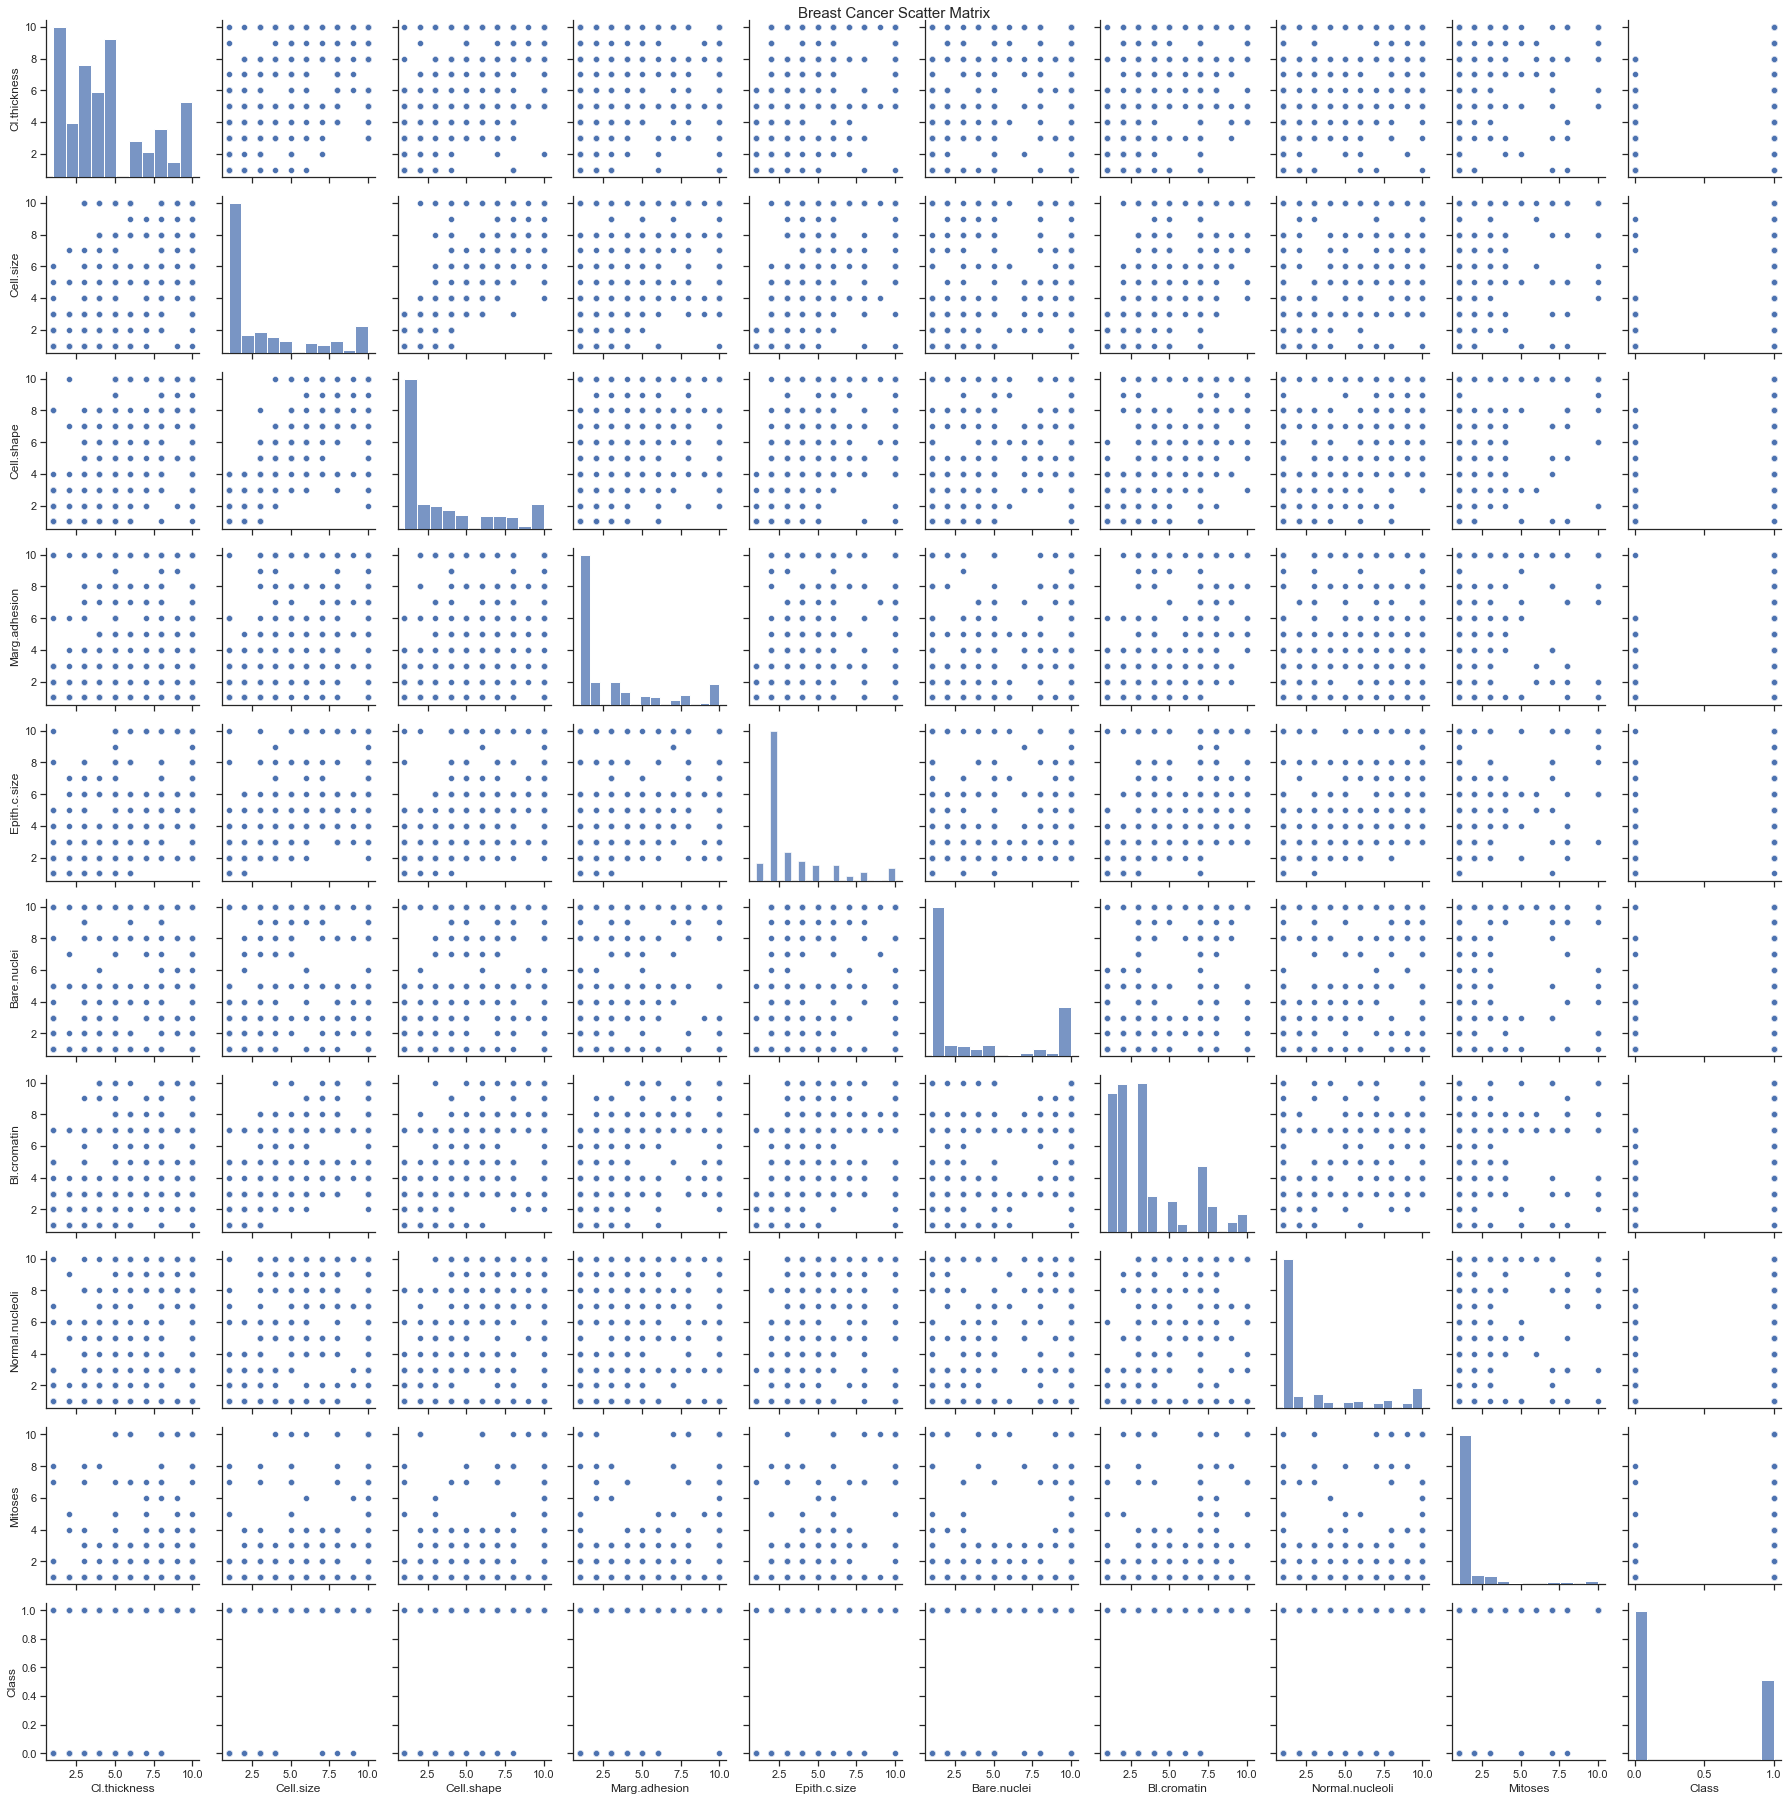


Elapsed time: 45.00s


In [149]:
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Compute scatter matrix for Breast Cancer dataset...\n" + colors.reset)
st = time.time()

# Bloxplot e Violinplot para os atributos da base de dados <vertebralcolumn-2C>
data = df.drop(df.columns[[-1]], axis=1) 
labels = list(df.columns[0:len(df.columns)-1])

plot_scatter_matrix(df, 
                    labels, 
                    "Breast Cancer", 
                    "Breast Cancer Scatter Matrix")

elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "\nElapsed time: %.2fs" % elapsed_time + colors.reset)

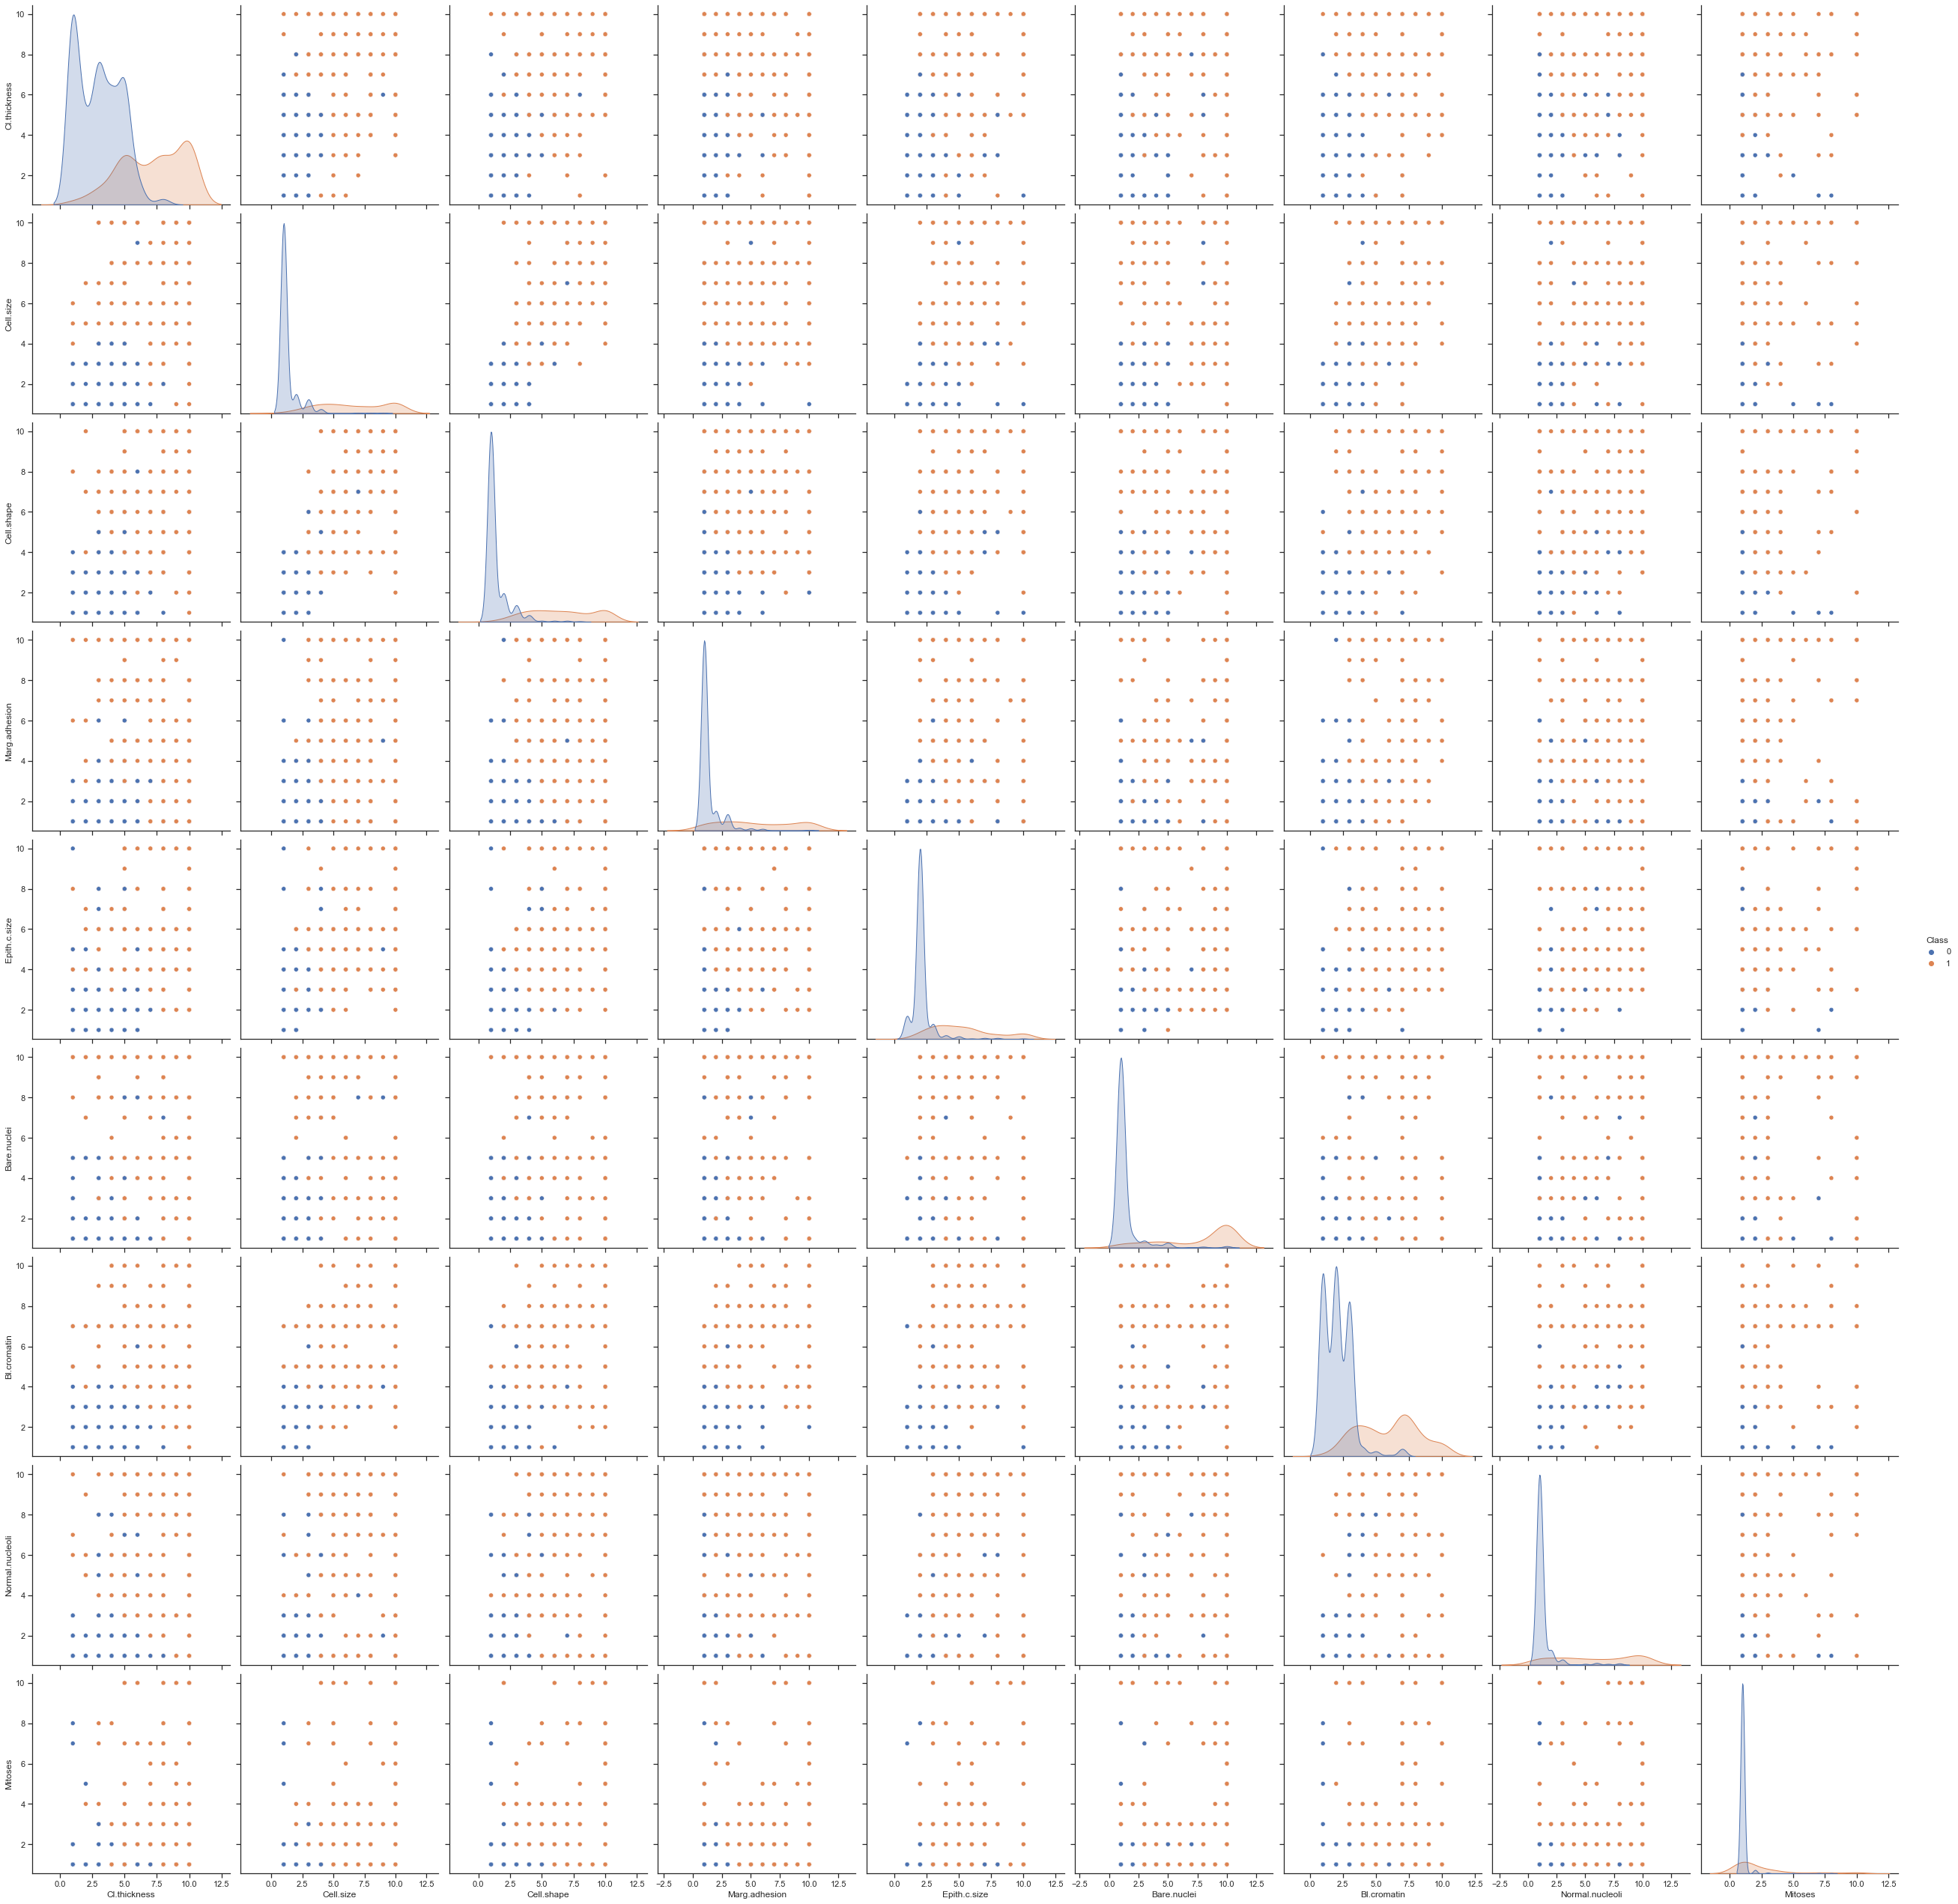

In [112]:
sns.set(style="ticks")
sns.pairplot(df, hue="Class", size = 4)

### Seleção dos conjuntos de teste e treinamento

In [90]:
# Cria uma coluna categoria a partir da classificação
# df['category']=df['class'].astype('category').cat.codes

# Preparação dos dados
df = df.to_numpy()
nrow,ncol = df.shape
y = df[:,-1]
X = df[:,:-1] # X = df[:,0:ncol-1]  # Não inclui a colunas 'class'

In [91]:
p = 0.2 # fraction of elements in the test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 42)

Vamos **normalizar os dados**, de modo a evitar o efeito da escala dos atributos.

In [92]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Dados transformados:" + colors.reset)
print(colors.bold + 'Media: ' + colors.reset, np.mean(X, axis = 0))
print(colors.bold + 'Desvio-padrão: ' + colors.reset, np.std(X, axis = 0))

Dados transformados:
Media:  [ 1.14603667e-16 -4.58414668e-17 -3.66731735e-16 -5.73018335e-17
  3.55271368e-16 -6.87622002e-17]
Desvio-padrão:  [1. 1. 1. 1. 1. 1.]


Selecionamos os conjuntos de teste e treinamento, sendo que $p$% dos dados serão usados como teste e (1-p)%, como treinamento.

In [93]:
p = 0.3 # fraction of elements in the test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 42)

In [94]:
# Inicialização das estatísticas para a confusion matrix
cm_acurracy_score, cm_recall_score, cm_precision_score, cm_f1_score = [], [], [], []

## KNeighborsClassifier

Para realizar a classificação, vamos usar a biblioteca scikit-learn (https://scikit-learn.org). É possível implementar o método usando métricas diferentes da Euclidiana, como as que podem ser vistas em: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

Vamos ajustar o modelo. Inicialmente, vamos considerar o método hold-out para selecionar o conjunto de teste e treinamento, que seleciona uma fração p de elementos para o conjunto de teste e (1-p), para treinamento. A seleção do modelo será feita mais adiante usando validação cruzada.

### KNeighborsClassifier com numero de vizinhos igual a 5

In [141]:
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Compute k-vizinhos modeling...\n" + colors.reset)
st = time.time()

# numero de vizinhos
k = 5 

# ajusta o modelo k-vizinhos
model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
model.fit(x_train,y_train)

# faz a predição no conjunto de teste
y_pred = model.predict(x_test) 

# O erro na classificação pode ser quantificado pela medida de acurácia.
score = accuracy_score(y_pred, y_test)
print(colors.bold + "Accuracy score (test set):" + colors.reset, score.round(4))

elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "\nElapsed time: %.2fs" % elapsed_time + colors.reset)

Compute k-vizinhos modeling...

Accuracy score (test set): 0.7527

Elapsed time: 0.01s


### KNeighborsClassifier com numero de vizinhos variando entre 1 e 30

Compute CV for KNeighbors Classifier modeling (breastcancer.csv)...

k: 01, accurace(train): 1.0000, accurace(test): 0.7835
k: 02, accurace(train): 0.8986, accurace(test): 0.7649
k: 03, accurace(train): 0.8889, accurace(test): 0.7781
k: 04, accurace(train): 0.8489, accurace(test): 0.7784
k: 05, accurace(train): 0.8505, accurace(test): 0.7645
k: 06, accurace(train): 0.8448, accurace(test): 0.7829
k: 07, accurace(train): 0.8500, accurace(test): 0.7924
k: 08, accurace(train): 0.8438, accurace(test): 0.7974
k: 09, accurace(train): 0.8228, accurace(test): 0.8017
k: 10, accurace(train): 0.8234, accurace(test): 0.7879
k: 11, accurace(train): 0.8198, accurace(test): 0.7740
k: 12, accurace(train): 0.8157, accurace(test): 0.7879
k: 13, accurace(train): 0.8198, accurace(test): 0.7877
k: 14, accurace(train): 0.8162, accurace(test): 0.7926
k: 15, accurace(train): 0.8162, accurace(test): 0.8063
k: 16, accurace(train): 0.8147, accurace(test): 0.7972
k: 17, accurace(train): 0.8146, accurace(test): 0.7

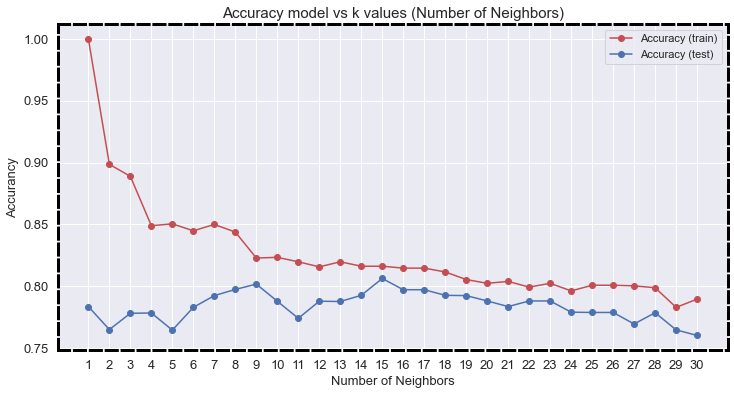

Best k: 15 (accurancy test set: 0.8063) 

Model fit with best k value in test set:
Best k: 15, accurace score: 0.7527

Elapsed time: 3.11s


In [142]:
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Compute CV for KNeighbors Classifier modeling (breastcancer.csv)...\n" + colors.reset)
st = time.time()

# number of folds for cross validation
cv = 10 
# Max number of neighbors
N = 31
# Inicialization
K, Score_train, Score_test = [], [], []
# Loop
for k in range(1, N):
    # modelo gerado e realização da validação cruzada
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    CV = cross_validate(model, x_train, y_train, cv=cv,  return_train_score=True)
    print('k: {:02d}, accurace(train): {:.4f}, accurace(test): {:.4f}'.format(k,CV['train_score'].mean(),CV['test_score'].mean()))
    # Append KNeighbors results
    K.append(k)
    Score_test.append(CV['test_score'].mean()) 
    Score_train.append(CV['train_score'].mean()) 

#----------------------------------------------------------------------------------------------------------------
# KNeighbors method
Best_k = plot_KNeighbors_scores(K, Score_test, Score_train)
# Usando todo o conjunto de treinamento, podemos ajustar o modelo e realizar a classificação no conjunto de teste.
model = KNeighborsClassifier(n_neighbors=Best_k, metric = 'euclidean')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(colors.bold + '\nModel fit with best k value in test set:' + colors.reset)
print('Best k: {:02d}, accurace score: {:.4f}'.format(Best_k,accuracy_score(y_pred, y_test)))

elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "\nElapsed time: %.2fs" % elapsed_time + colors.reset)

### KNeighborsClassifier usando GridSearchCV (numero de vizinhos variando entre 1 e 30)

In [143]:
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Compute KNeighbors Classifier vs k values...\n" + colors.reset)
st = time.time()

N  = 30
cv = 10

# create new a knn model
knn2 = KNeighborsClassifier(metric='euclidean') #sklearn.neighbors.DistanceMetric para mais detalhes e opções de métricas
# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, N)}
# use gridsearch to test all values for n_neighbors
model = GridSearchCV(knn2, param_grid, cv=cv)
# fit model to train data
model.fit(x_train,y_train) 
# predict the classes
y_pred = model.predict(x_test)

elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Elapsed time: %.2fs" % elapsed_time + colors.reset)

Compute KNeighbors Classifier vs k values...

Elapsed time: 0.64s


### Using pandas/dataframe to collect KNeighborsClassifier model results

In [144]:
# dataframe to store model results
df_knn=pd.DataFrame(model.cv_results_)

#labels=list(df_knn.columns)
#labels

In [145]:
# Score results with test set
score = df_knn['mean_test_score']

# Best results for Bk_knn - predict on test set (fit model to train data)
Bk_knn = np.argmax(score)+1
BScore_knn = score[Bk_knn]

print((colors.bold + "Best k: "  + colors.reset + "{:02d} ({:.6f})").format(Bk_knn, score[Bk_knn-1]))
print((colors.bold + "knn_gscv.best_params_: " + colors.reset), knn_gscv.best_params_)
print((colors.bold + "knn_gscv.best_estimator_: " + colors.reset),knn_gscv.best_estimator_)
print((colors.bold + "knn_gscv.best_score_: " + colors.reset), knn_gscv.best_score_.round(6))

Best k: 15 (0.806277)
knn_gscv.best_params_:  {'n_neighbors': 15}
knn_gscv.best_estimator_:  KNeighborsClassifier(metric='euclidean', n_neighbors=15)
knn_gscv.best_score_:  0.806277


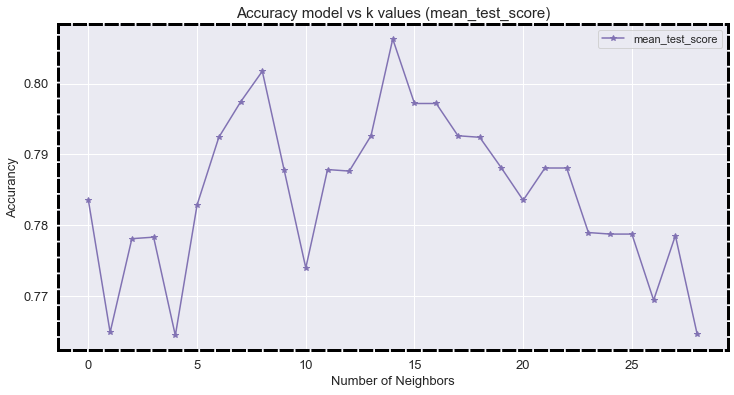

Best k: 15 (0.806277) 


In [146]:
#----------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(score, '-m*', label = 'mean_test_score')
plt.title('Accuracy model vs k values (mean_test_score)', fontsize=15)
plt.xlabel('Number of Neighbors', fontsize=13)
plt.ylabel('Accurancy', fontsize=13)
plt.legend()
ax.tick_params(labelsize=13)
format_plot(ax)
plt.show()
print("Best k: {:02d} ({:.6f}) ".format(Bk_knn, score[Bk_knn-1]))


Confusion matrix, without normalization:


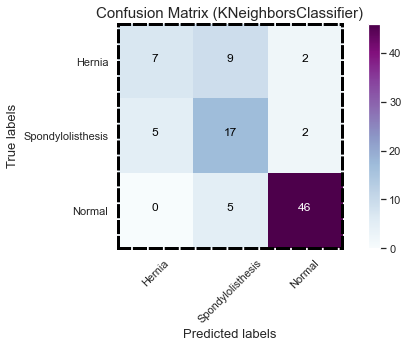


Confusion matrix classifcation report:
                   precision    recall  f1-score   support

           Hernia       0.58      0.39      0.47        18
           Normal       0.55      0.71      0.62        24
Spondylolisthesis       0.92      0.90      0.91        51

         accuracy                           0.75        93
        macro avg       0.68      0.67      0.67        93
     weighted avg       0.76      0.75      0.75        93



In [147]:
#----------------------------------------------------------------------------------------------------------------
# Confusion Matrix grafic
cm = confusion_matrix(y_test, y_pred)
cmap="BuPu" # cmap="coolwarm" # "coolwarm", "viridis", PiYG", "RdBu", "Blues", "BuPu", "Greens", "YlGnBu", plt.cm.rainbow
Normalize = False
plot_confusion_matrix(cm, classes, Normalize, "Confusion Matrix (KNeighborsClassifier)", cmap)
#  Confusion Matrix Report 
print(colors.bold + "\nConfusion matrix classifcation report:" + colors.reset)
print(classification_report(y_test, y_pred))
#  Confusion Matrix scores: acurracy, recall, precision and F1
[cm_acurracy_score, cm_recall_score, cm_precision_score, cm_f1_score] = confusion_matrix_scores(y_test, 
                                                                                                y_pred,
                                                                                                cm_acurracy_score, 
                                                                                                cm_recall_score, 
                                                                                                cm_precision_score, 
                                                                                                cm_f1_score)

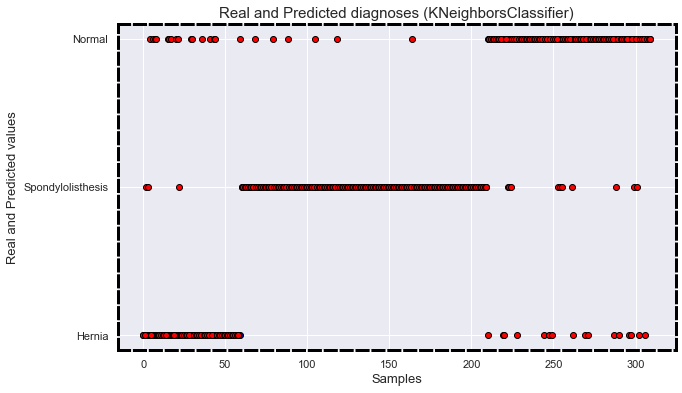

In [162]:
# Predição sobre todo o conjunto de dados usando KNeighborsClassifier
y_pred = model.predict(X)

# Decodifica os labels reais e predição usando LabelEncoder
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_pred_enc = encoder.fit_transform(y_pred)

# Plot funciona sem ter necessidade de decodificar os labels do diagnóstico
plot_real_predicted_values("KNeighborsClassifier", X, y, y_pred)

## Regressão logística

In [152]:
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Compute CV for LogisticRegression classifier modeling...\n" + colors.reset)
st = time.time()

# Modelo LogisticRegression
# solver = {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
model = LogisticRegression(solver = 'lbfgs', max_iter = 1e4)
model.fit(x_train, y_train)

# Predição sobre o conjunto de teste
y_pred = model.predict(x_test)

# Erro na classificação pode ser quantificado pela medida de acurácia.
score = model.score(x_test, y_test)
print(colors.bold + "Logistic regression accuracy score (test set):" + colors.reset, score.round(4))

elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "\nElapsed time: %.2fs" % elapsed_time + colors.reset)

Compute CV for LogisticRegression classifier modeling...

Logistic regression accuracy score (test set): 0.828

Elapsed time: 0.05s



Confusion matrix, without normalization:


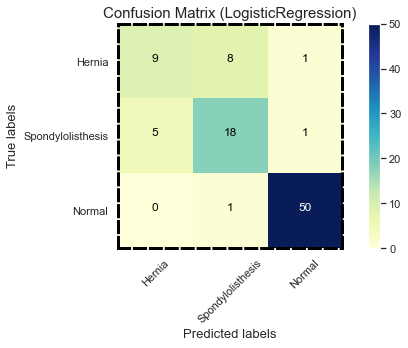


Confusion matrix classification report:
                   precision    recall  f1-score   support

           Hernia       0.64      0.50      0.56        18
           Normal       0.67      0.75      0.71        24
Spondylolisthesis       0.96      0.98      0.97        51

         accuracy                           0.83        93
        macro avg       0.76      0.74      0.75        93
     weighted avg       0.82      0.83      0.82        93



In [153]:
#----------------------------------------------------------------------------------------------------------------
# Confusion Matrix grafic
cm = confusion_matrix(y_test, y_pred)
cmap="YlGnBu" # cmap="coolwarm" # "coolwarm", "viridis", PiYG", "RdBu", "Blues", "BuPu", "Greens", "YlGnBu", plt.cm.rainbow
Normalize = False
plot_confusion_matrix(cm, classes, Normalize, "Confusion Matrix (LogisticRegression)", cmap)
#  Confusion Matrix Report 
print(colors.bold + "\nConfusion matrix classification report:" + colors.reset)
print(classification_report(y_test, y_pred))
#  Confusion Matrix scores: acurracy, recall, precision and F1
[cm_acurracy_score, cm_recall_score, cm_precision_score, cm_f1_score] = confusion_matrix_scores(y_test, 
                                                                                                y_pred,
                                                                                                cm_acurracy_score, 
                                                                                                cm_recall_score, 
                                                                                                cm_precision_score, 
                                                                                                cm_f1_score)

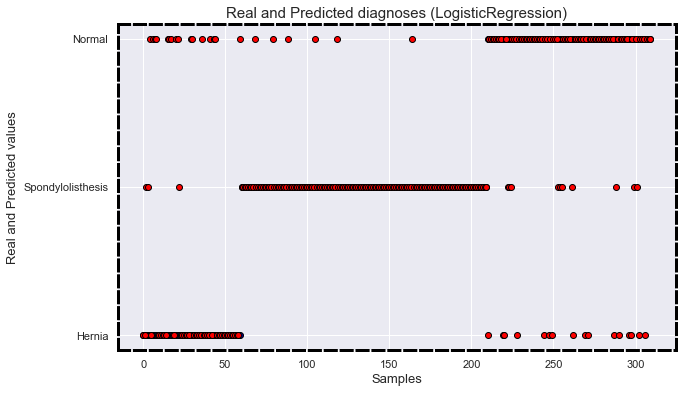

In [163]:
# Predição sobre todo o conjunto de dados usando LogisticRegression
y_pred = model.predict(X)

# Decodifica os labels reais e predição usando LabelEncoder
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_pred_enc = encoder.fit_transform(y_pred)

# Plot funciona sem ter necessidade de decodificar os labels do diagnóstico
plot_real_predicted_values("LogisticRegression", X, y, y_pred)

## Naive Bayes

In [164]:
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "Compute naive bayes modeling...\n" + colors.reset)
st = time.time()

# Classificador naive bayes
model = GaussianNB()

# Model fit
model.fit(x_train, y_train)

# Predição sobre o conjunto de teste
y_pred = model.predict(x_test)

# Erro na classificação pode ser quantificado pela medida de acurácia.
score = model.score(x_test, y_test)
print(colors.bold + "naive bayes regression accuracy score (test set):" + colors.reset, score.round(1))

elapsed_time = time.time() - st
print(colors.bold + colors.bg.lightgrey + colors.fg.black + "\nElapsed time: %.2fs" % elapsed_time + colors.reset)

Compute naive bayes modeling...

naive bayes regression accuracy score (test set): 0.8

Elapsed time: 0.00s



Confusion matrix, without normalization:


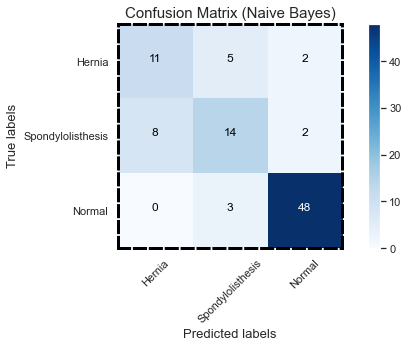


Confusion matrix classification report:
                   precision    recall  f1-score   support

           Hernia       0.58      0.61      0.59        18
           Normal       0.64      0.58      0.61        24
Spondylolisthesis       0.92      0.94      0.93        51

         accuracy                           0.78        93
        macro avg       0.71      0.71      0.71        93
     weighted avg       0.78      0.78      0.78        93



In [165]:
#----------------------------------------------------------------------------------------------------------------
# Confusion Matrix grafic
cm = confusion_matrix(y_test, y_pred)
cmap="Blues" # cmap="coolwarm" # "coolwarm", "viridis", PiYG", "RdBu", "Blues", "BuPu", "Greens", "YlGnBu", plt.cm.rainbow
Normalize = False
plot_confusion_matrix(cm, classes, Normalize, "Confusion Matrix (Naive Bayes)", cmap)
#  Confusion Matrix Report 
print(colors.bold + "\nConfusion matrix classification report:" + colors.reset)
print(classification_report(y_test, y_pred))
#  Confusion Matrix scores: acurracy, recall, precision and F1
#  Confusion Matrix scores: acurracy, recall, precision and F1
[cm_acurracy_score, cm_recall_score, cm_precision_score, cm_f1_score] = confusion_matrix_scores(y_test, 
                                                                                                y_pred,
                                                                                                cm_acurracy_score, 
                                                                                                cm_recall_score, 
                                                                                                cm_precision_score, 
                                                                                                cm_f1_score)

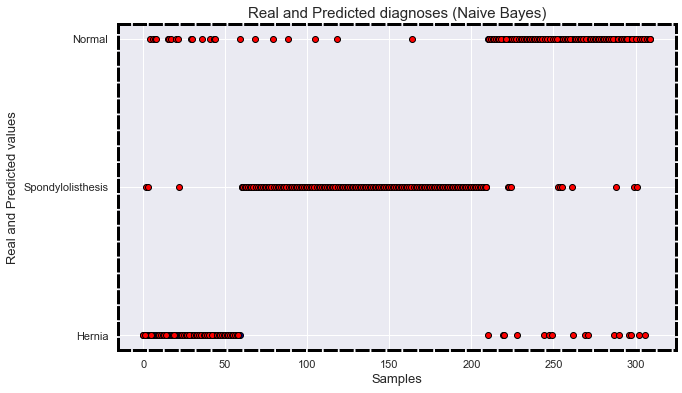

In [166]:
# Predição sobre todo o conjunto de dados usando Naive Bayes
y_pred = model.predict(X)

# Decodifica os labels reais e predição usando LabelEncoder
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_pred_enc = encoder.fit_transform(y_pred)

# Plot funciona sem ter necessidade de decodificar os labels do diagnóstico
plot_real_predicted_values("Naive Bayes", X, y, y_pred)

In [158]:
models = [ ('KNeighbors Classifier',          cm_acurracy_score[0], cm_recall_score[0], cm_precision_score[0], cm_f1_score[0] ),
           ('Logistic Regression Classifier', cm_acurracy_score[1], cm_recall_score[1], cm_precision_score[1], cm_f1_score[1] ),
           ('Naive Bayes Classifier',         cm_acurracy_score[2], cm_recall_score[2], cm_precision_score[2], cm_f1_score[2] ),
         ]

In [159]:
classifiers = pd.DataFrame(data = models, columns=['Model', 'CM Acurracy score', 'CM Recall score', 'CM Precision score', 'CM F1 score'])
idx = np.argmax(classifiers['CM Acurracy score'])

classifiers

,Model,CM Acurracy score,CM Recall score,CM Precision score,CM F1 score
0,KNeighbors Classifier,0.752688,"[0.3888888888888889, 0.7083333333333334, 0.901...","[0.5833333333333334, 0.5483870967741935, 0.92]","[0.4666666666666666, 0.6181818181818182, 0.910..."
1,Logistic Regression Classifier,0.752688,"[0.3888888888888889, 0.7083333333333334, 0.901...","[0.5833333333333334, 0.5483870967741935, 0.92]","[0.4666666666666666, 0.6181818181818182, 0.910..."
2,Naive Bayes Classifier,0.827957,"[0.5, 0.75, 0.9803921568627451]","[0.6428571428571429, 0.6666666666666666, 0.961...","[0.5625000000000001, 0.7058823529411765, 0.970..."


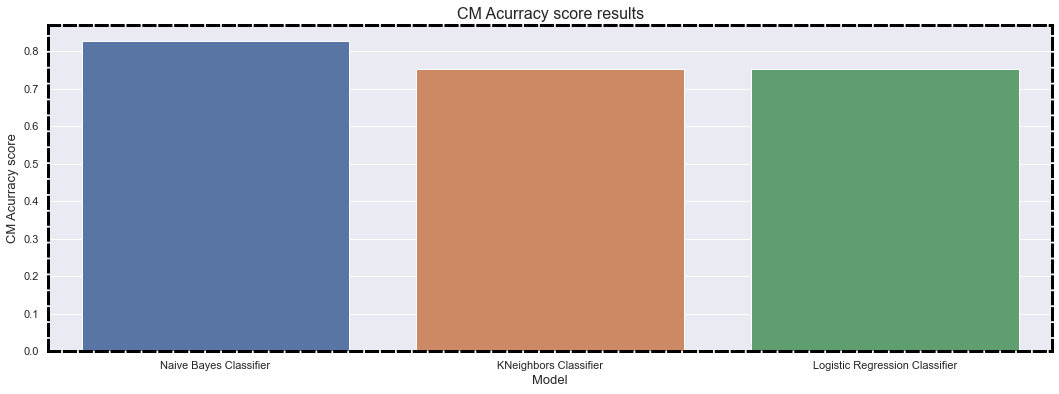

Best classifier:  Naive Bayes Classifier
Acurracy score: 0.8280


In [160]:
f, axes = plt.subplots(figsize=(18,6))
classifiers.sort_values(by=['CM Acurracy score'], ascending=False, inplace=True)
sns.barplot(x='Model', y='CM Acurracy score', data=classifiers, ax = axes)
axes.set_xlabel('Model', size=13)
axes.set_ylabel('CM Acurracy score', size=13)
plt.title('CM Acurracy score results', size=16)
format_plot(axes)
plt.show()

print('Best classifier: ', classifiers.loc[idx, 'Model'])
print('Acurracy score: {:.4f}'.format(classifiers.loc[idx, 'CM Acurracy score']))